In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

# 변경하고자 하는 새로운 디렉토리 경로
new_directory = '/content/drive/MyDrive'

# 디렉토리 위치 변경
os.chdir(new_directory)

# 변경된 디렉토리 경로 출력
print("Current directory:", os.getcwd())


Current directory: /content/drive/MyDrive


# Optimizer 매개변수 갱신

▪ 매개변수 갱신을 위한 기반 클래스

▪ 구체적인 최적화 기법은 Optimizer 클래스를 상속한 자식 클래스에서 구현함

▪ 초기화 메서드 target과 hooks 라는 두 개의 인스턴스 변수를 초기화

▪ setup 메소드는 매개변수를 갖는 클래스를 인스턴스 변수인 target으로 설정

▪ update 메서드는 모든 매개변수를 갱신

▪ 구체적인 매개변수 갱신은 update_one 메서드에서 수행, 자식 클래스에서 재정의

▪ 전처리는 add_hook 메서드를 사용하여 전처리 수행


In [14]:
class Optimizer:
  def __init__(self, target):
    self.target = target
    self.hooks = []

  def setup(self, target):
    self.target = target
    return self

  def update(self):
    params = [p for p in self.target.parameters() if p.grad is not None]
    for f in self.hooks:
      f(params)

    for param in params:
      self.update_one(param)

  def update_one(self, param):
    raise NotImplementedError()

  def add_hook(self, f):
    self.hooks.append(f)

## SGD 클래스 구현
- 경사하강법으로 매개변수 갱신
- Optimizer 클래스 상속

In [15]:
class SGD(Optimizer):
  def __init__(self, lr= 0.01):
    super(). __init__()
    self.lr = lr

  def update_one(self, param):
    param.data -= self.lr * param.grad.data

In [ ]:
lr = 0.2
max_iter = 10000
hidden_size = 10

class TwoLaterNet(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.l1 = L.Linear(hidden_size)
    self.l2 = L.Linear(out_size)

  def forward(self, x):
    y = F.sigmoid(self.l1(x))
    y = self.l2(y)
    return y

model = TwoLaterNet(hidden_size, 1)
for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)
  model.cleargrads()
  loss.backward()
  for p in model.params():
    p.data -= lr * p.grad.data
  if i % 1000 == 0:
    print(loss)

In [17]:
from dezero import optimizers

In [ ]:
model = MLP((hidden_size, 1))
optimizers = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
  y_pred = model(x)
  loss = F.mean_squared_error(y, y_pred)
  model.cleargrads()
  loss.backward()

  optimizers.update()
  if i % 1000 == 0:
    print(loss)

## MonmentumSGD 구현코드
▪ 속도에 해당하는 데이터, 딕셔너리 타입의 인스턴스 변수 self.vs에 유지

▪ 초기화 시에는 vs에 아무것도 담겨있지 않음

▪ Update_one() 이 처음 호출될 때 매개변수와 같은 타입의 데이터를 생성

▪ 구현한 학습 코드에서 손쉽게 Momentum으로 전환

In [20]:
class MomentumSGD(Optimizer):
  def __init__(self, lr = 0.01, momentum = 0.9):
    super().__init__()
    self.lr = lr
    self.momentum = momentum
    self.vs = {}

  def update_one(self, param):
    v_key = id(param)
    if v_key not in self.vs:
      xp = cuda.get_array_module(param.data)
      self.vs[v_key] = xp.zeros_like(param.data)

    v = self.vs[v_key]
    v *= self.momentum
    v -= self.lr ** param.grad.data
    param.data += v


## 다중 클래스 분류
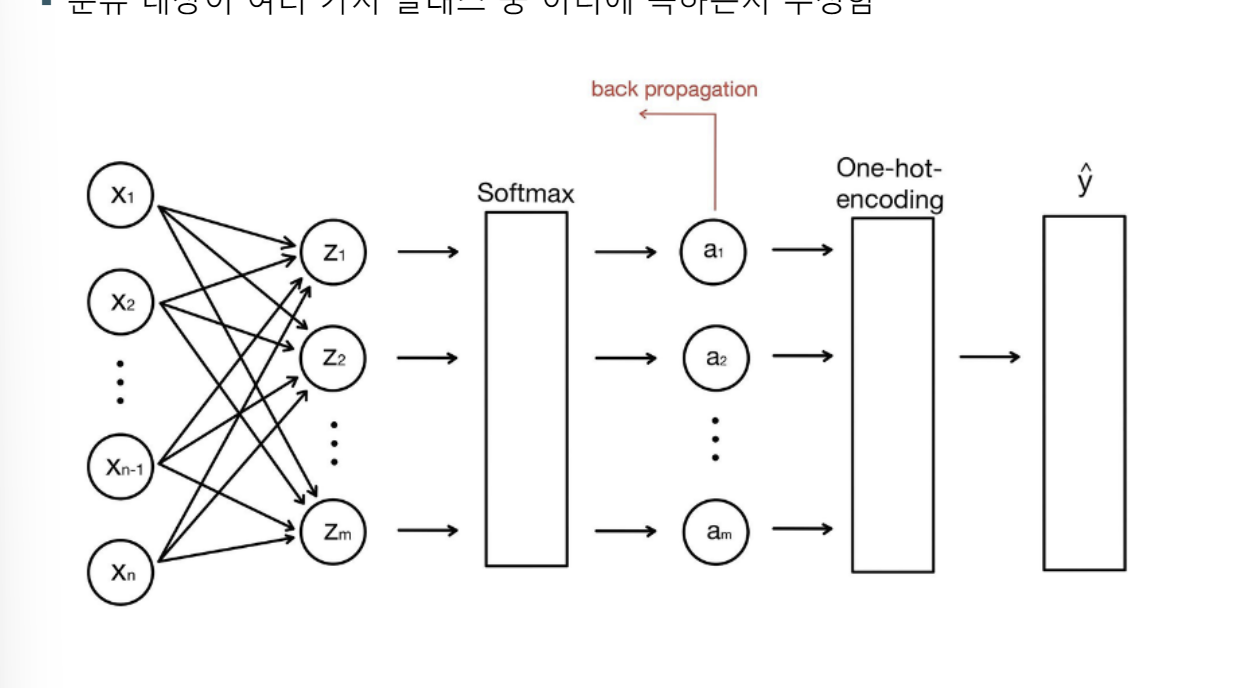

### get_item 함수

In [22]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3], [4,5,6]]))
y = F.get_item(x,1)
print(y)

variable([4 5 6])


In [23]:
y.backward()
print(x.grad)

variable([[0 0 0]
          [1 1 1]])


### 슬라이스

In [25]:
x = Variable(np.array([[1,2,3], [4,5,6]]))
indices = np.array([0,0,1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


특수 메서드로 설정

In [26]:
Variable.__getitem__ = F.get_item

y = x[1]
print(y)

y = x[:,2]
print(y)

variable([4 5 6])
variable([3 6])


## 소프트맥스 함수

- 선형 회귀 때 이용한 신경망을 그대로 사용 가능
- 입력데이터의 차원 수 가 2이고 3개의 클래스를 분류 하는 문제

In [30]:
from dezero.models import MLP
model = MLP((10,3))

x = np.array([[0.2, -0.4]])
y = model(x)
print(y)

variable([[-0.25979522  0.84037143 -0.16076347]])


In [32]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
  x = as_variable(x)
  y = F.exp(x)
  sum_y = F.sum(y)
  return y / sum_y

In [33]:
model = MLP((10,3))
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[0.00559091 0.55922952 0.3379106 ]])
variable([[0.24190995 0.42081957 0.33727048]])


### 배치 데이터에도 소프트맥수 함수 적용

In [35]:
def softmax_simple(x, axis=1):
  x = as_variable(x)
  y = exp(x)
  sum_y = sum(y, axis = axis, keepdims = True)
  return y / sum_y

## 교차 엔트로피 오차
- 다중 클래스 분류에 적합한 손실 함수
- 정답 데이터 1 , 틀린 데이터 0
- 원핫 벡터

In [36]:
def softmax_cross_entropy_simple(x, t):
  x, t = as_variable(x), as_variable(t)
  N = x.shape[0]
  p = softmax(x)
  p = clip(p, 1e-15, 1.0)
  log_p = log(p)
  tlog_p = log_p[np.arange(N), t.data]
  y = -1 * sum(tlog_p) / N
  return y


## 스파이럴 데이터셋
▪ train=True 면 학습용 데이터를 반환, False 면 테스트용 데이터를 반환

▪ 반환되는 값은 입력 데이터인 x와 정답 데이터인 t 임

▪ x와 t는 모두 ndarray 인스턴스이며, 형상은 각각 (300, 2) 와 (300, ) 임

▪ 문제는 3클래스 분류이므로 t이 원소는 0, 1, 2 중 하나가 됨


In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

In [ ]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t= dezero.datasets.get_spiral(train =True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

In [ ]:
data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
  # (3) Shuffle index for data
  index= np.random.permutation (data_size)
  sum_loss = 0

  for i in range(max_iter):
    #(4) 미니배치 생성
    batch_index = index[i * batch_size: (i+1) * batch_size]
    batch_x = x[batch_index]
    batch_t = t[batch_index]
    #(5) 기울기 산출 / 매개변수 갱신
    y= model (batch_x)
    loss = F.softmax_cross_entropy(y, batch_t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(batch_t)
#(6) Print loss every epoch
  avg_loss = sum_loss / data_size
  print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

## Dataset 클래스 쿠현

In [7]:
class Dataset:
  def __init__(self, train = True):
    self.train = train
    self.transform = transform
    self.target_transform = target_transform
    if self.trainsform is None:
      self.transform = lambda x: x
    if self.target_transform is None:
      self.target_transform = lambda x: x
    self.data = None
    self.label = None
    self.prepare()

  def __getitem__(self, index):
    assert np.issaclar(index)
    if self.label is None:
      return self.transform(self.data[index]), None
    else:
      return self.transform(self.data[index]),\
      self.target_transform(self.label[index])

  def __len__(self):
    return len(self.data)

  def prepare(self):
    pass

class Spiral(Dataset):
  def prepare(self):
    self.data, self.label = get_spiral(self.train)


## 큰데이터셋 처리
▪작은 데이터셋은 Dataset 클래스의 인스턴스 변수인 data와 label에 직접 ndarray 인스턴스
를 유지해도 무리가 없음

▪ 큰 데이터셋의 구현 방식은 지금의 방식을 사용할 수 없음

▪ data 디렉터리와 label 디렉터리에 각가 100만 개의 데이터가 저장되어 있다고 가정

In [8]:
class BigData(Dataset):
  def __getitem__(idex):
    x = np.load('data/{}.npy'.format(index))
    t = np.load('label/{}.npy'.fomat(index))
    return x, t

  def __len():
    return 1000000

## 데이터 이어붙이기
신경망 입력 행태로의 데이터 준비
- 인덱스를 지정하여 batch에 여러 데이터가 리스트로 저장
- ndarray인스턴스로 변환